In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [82]:
#file     = uproot.open('./20230523/laser000010.bin.root')
#file     = uproot.open('../20230525/dark_tr100000013.bin.root')
#file     = uproot.open('./20230529/laser_tr60_bl129_1000ns_delay240ns_CFD000025.bin.root')
#file     = uproot.open('./20230530/laser_tr60_bl129_1000ns_delay240ns_CFD000027.bin.root')
#file     = uproot.open('./20230530/laser_tr60_bl129_1000ns_delay240ns_CFD_qdcfilter200ns000028.bin.root')
#file     = uproot.open('./20230530/laser_tr60_bl129_1000ns_delay240ns_CFD_qdcfilter100ns000029.bin.root')
#file     = uproot.open('/Users/ishiwata/grams/data/20230616/liquidN_tr150_bl129000085.bin.root')
file     = uproot.open("/Users/ishiwata/grams/data/20230620/liquidN_HV174_tr56_bl129000087.bin.root")

header   = file['header']
tree     = file['tree']
QDC      = tree.arrays(['qdc'], library='numpy')['qdc']
waveform = tree.arrays(['waveform'], library='numpy')['waveform']
timebin_width = header.arrays(['timebin_width'], library='numpy')['timebin_width'] #ns
wave_num = tree.arrays(['wave_num'], library='numpy')['wave_num'][0]
time_array    = np.arange(wave_num) * timebin_width #* ns2us

In [83]:
#FFTで周期的な成分を除去
num=len(waveform)
fft_wave=np.zeros((len(waveform),1000))
for i in range(len(waveform)):
    offset=abs(np.min(waveform[i]))
    X=waveform[i]
    N =len(X)      #データ長
    fs=1e+9          #サンプリング周波数
    dt =1/fs       # サンプリング間隔
    t = np.arange(0.0, N*dt, dt) #時間軸
    freq = np.linspace(0, fs,N) #周波数軸
    fn=1/dt/2     #ナイキスト周波数
    F=np.fft.fft(X)/(N/2)
    F[(freq>fn)]=0 #ナイキスト周波数以降をカット
    X_0=np.abs(F)
    threshold=np.amax(X_0)*0.03
    peak_index=np.where(X_0 > threshold) #threshold以上のpeak_indexを抽出
    peak_freq=[]
    for n in peak_index[0]:
        if freq[n] > 1e7:
            peak_freq.append(freq[n])

    for hz in peak_freq:
        F[(freq==hz)]=0
    X_1=np.abs(F) #trendを除去した波形(横軸周波数)
    X_2=np.real(np.fft.ifft(F))*N #trendを除去した波形(横軸時間[ns]) waveform

    fft_wave[i]=X_2

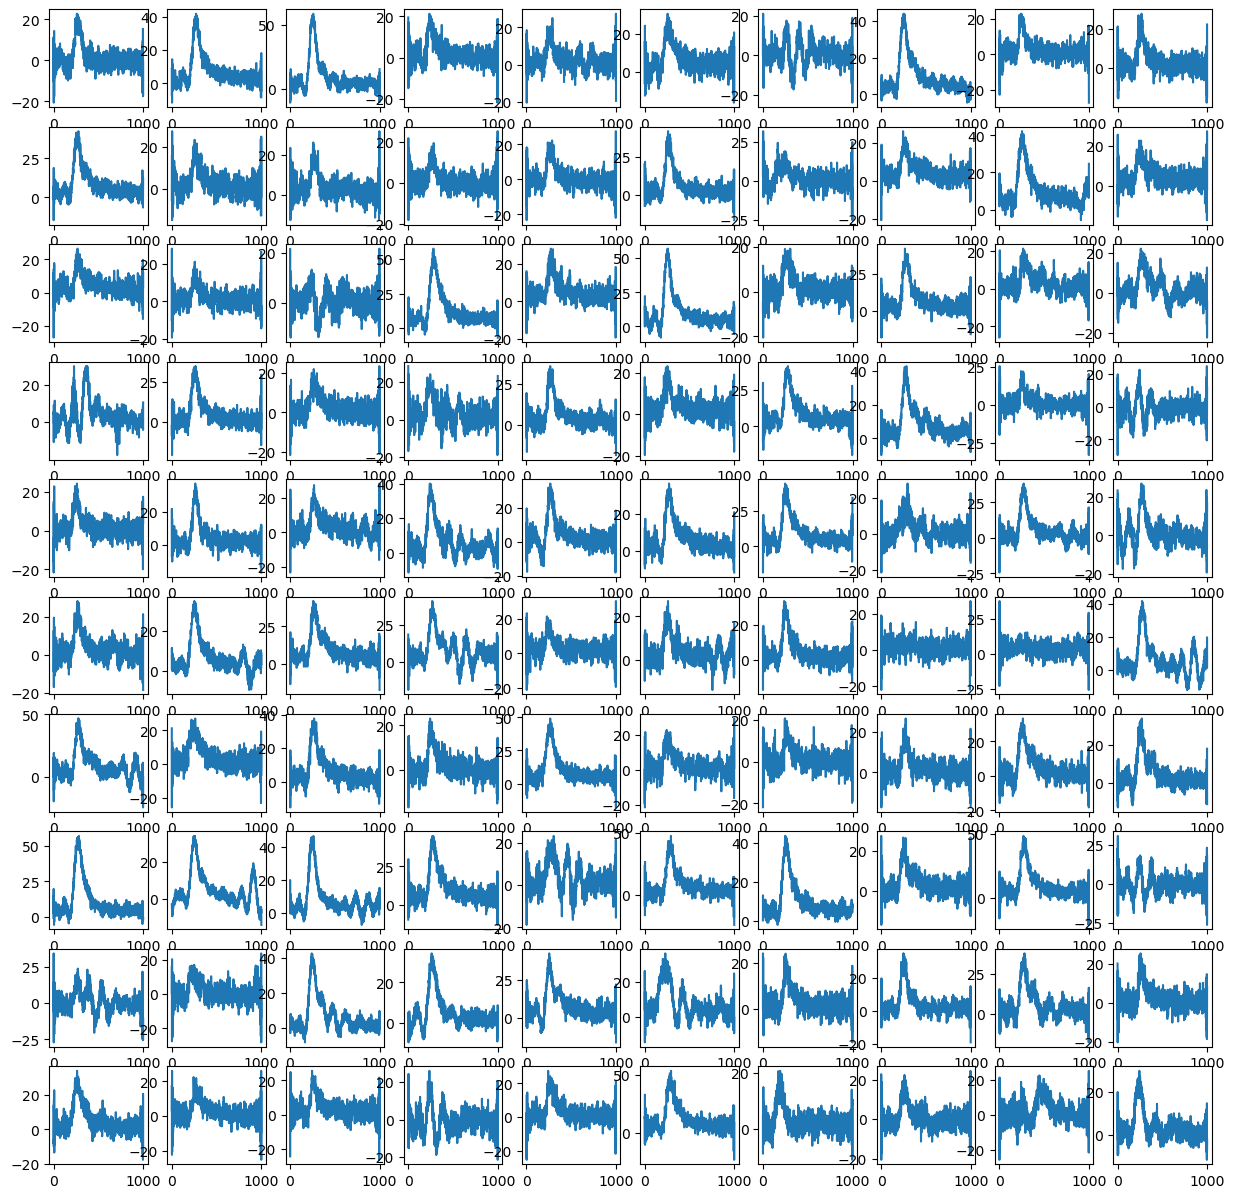

In [84]:
plt.figure(figsize=(15,15))
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.plot(time_array,fft_wave[i])


In [85]:
#baseline補正
blcorr_wave=np.zeros((num,1000))
for i in range(num):
    baseline=np.average(fft_wave[i][0:150])
    blcorr_wave[i]=fft_wave[i]-baseline


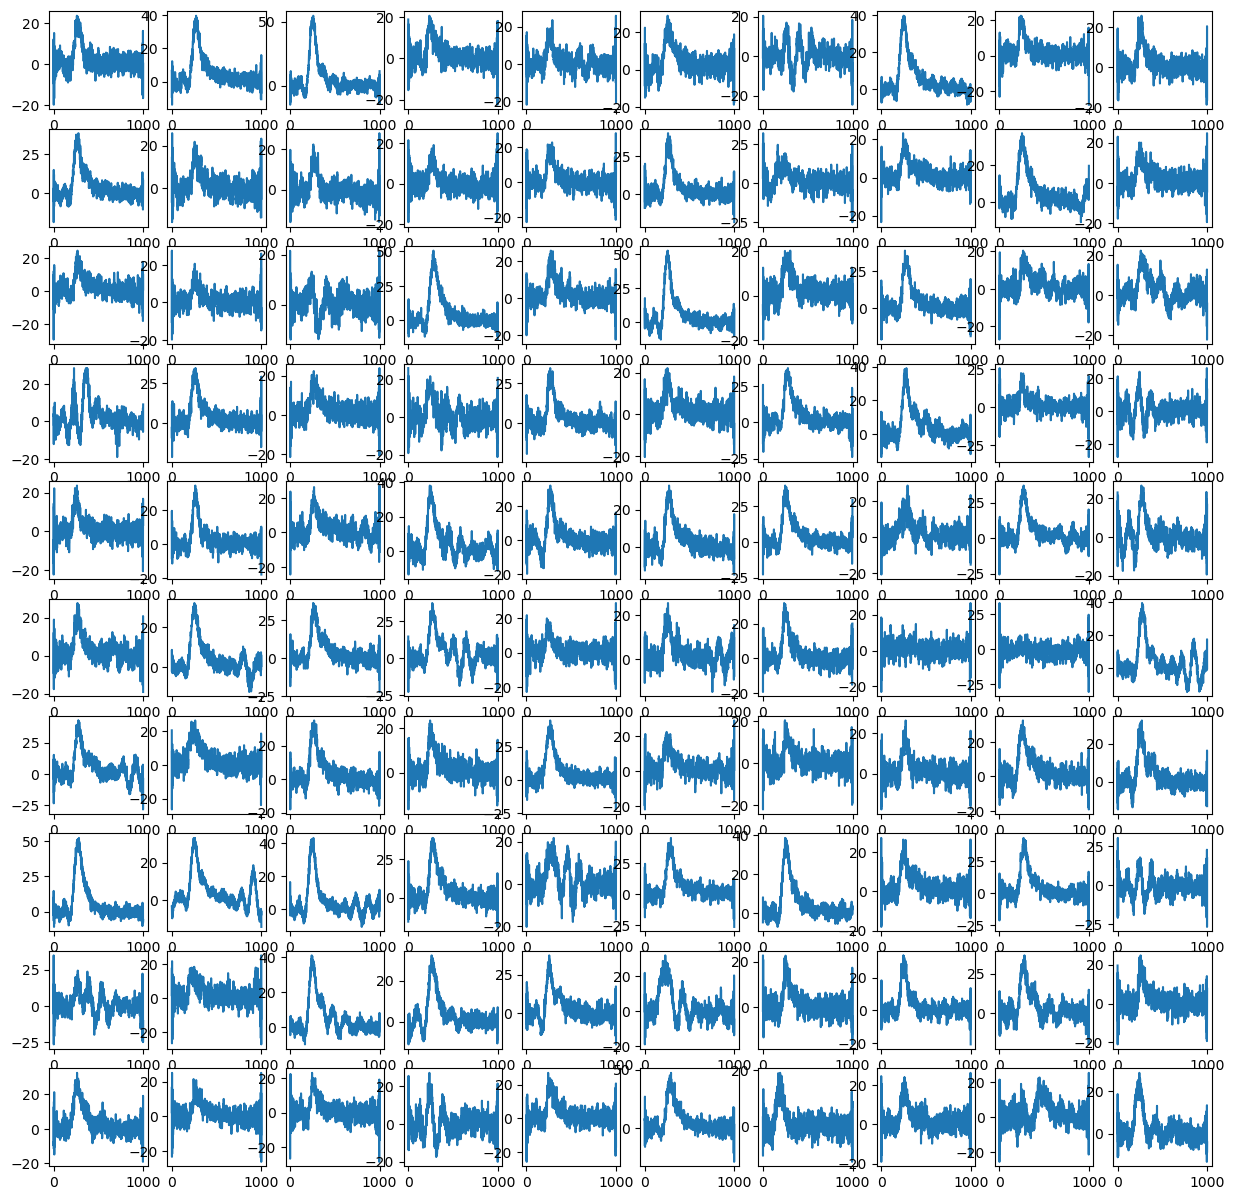

In [86]:
plt.figure(figsize=(15,15))
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.plot(time_array,blcorr_wave[i])
    

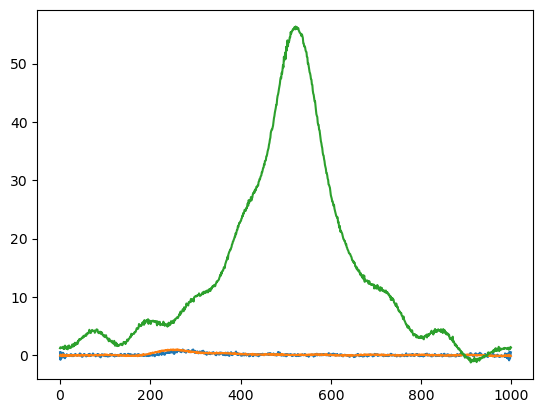

In [87]:
from scipy import signal as sg
#input1
peak_index1=np.argmax(blcorr_wave[24])
sig_noise=blcorr_wave[24]/blcorr_wave[24][peak_index1]

#input2:template waveform
peak_index2=np.argmax(blcorr_wave[7])
#sig_ref=blcorr_wave[79][peak_index2:peak_index2+600]/blcorr_wave[79][peak_index2]
sig_ref=blcorr_wave[7]/blcorr_wave[7][peak_index2]

corr = sg.correlate(sig_noise, sig_ref, mode='same') #/ len(sig_ref)
plt.plot(time_array,sig_noise)
#plt.plot(time_array[peak_index2:peak_index2+600],sig_ref)
plt.plot(time_array,sig_ref)
plt.plot(corr)

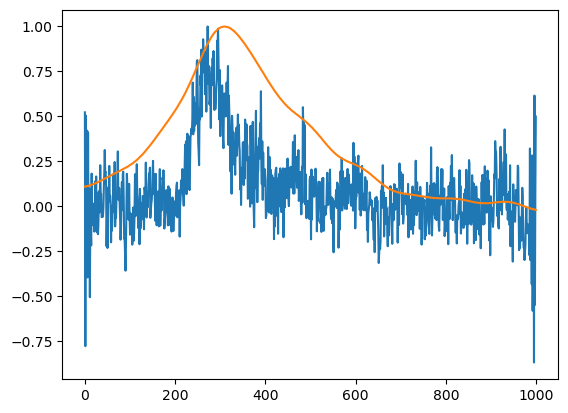

In [88]:
filt_wave=sg.convolve(sig_noise,corr/np.max(corr),mode="same")

plt.plot(time_array,sig_noise)
plt.plot(time_array,filt_wave/np.max(filt_wave))
#plt.plot(time_array,filt_wave)

In [76]:
filt_wave=np.zeros((num,1000))
for i in range(num):
    #input1
    peak_index1=np.argmax(blcorr_wave[i])
    sig_noise=blcorr_wave[i]/blcorr_wave[i][peak_index1]

    #input2
    peak_index2=np.argmax(blcorr_wave[34])
    #sig_ref=blcorr_wave[79][peak_index2:peak_index2+600]/blcorr_wave[79][peak_index2]
    sig_ref=blcorr_wave[34]/blcorr_wave[34][peak_index2]

    corr = sg.correlate(sig_noise, sig_ref, mode='same') #/ len(sig_ref)
    filt_wave[i]=sg.convolve(sig_noise,corr/np.max(corr),mode="same")

    


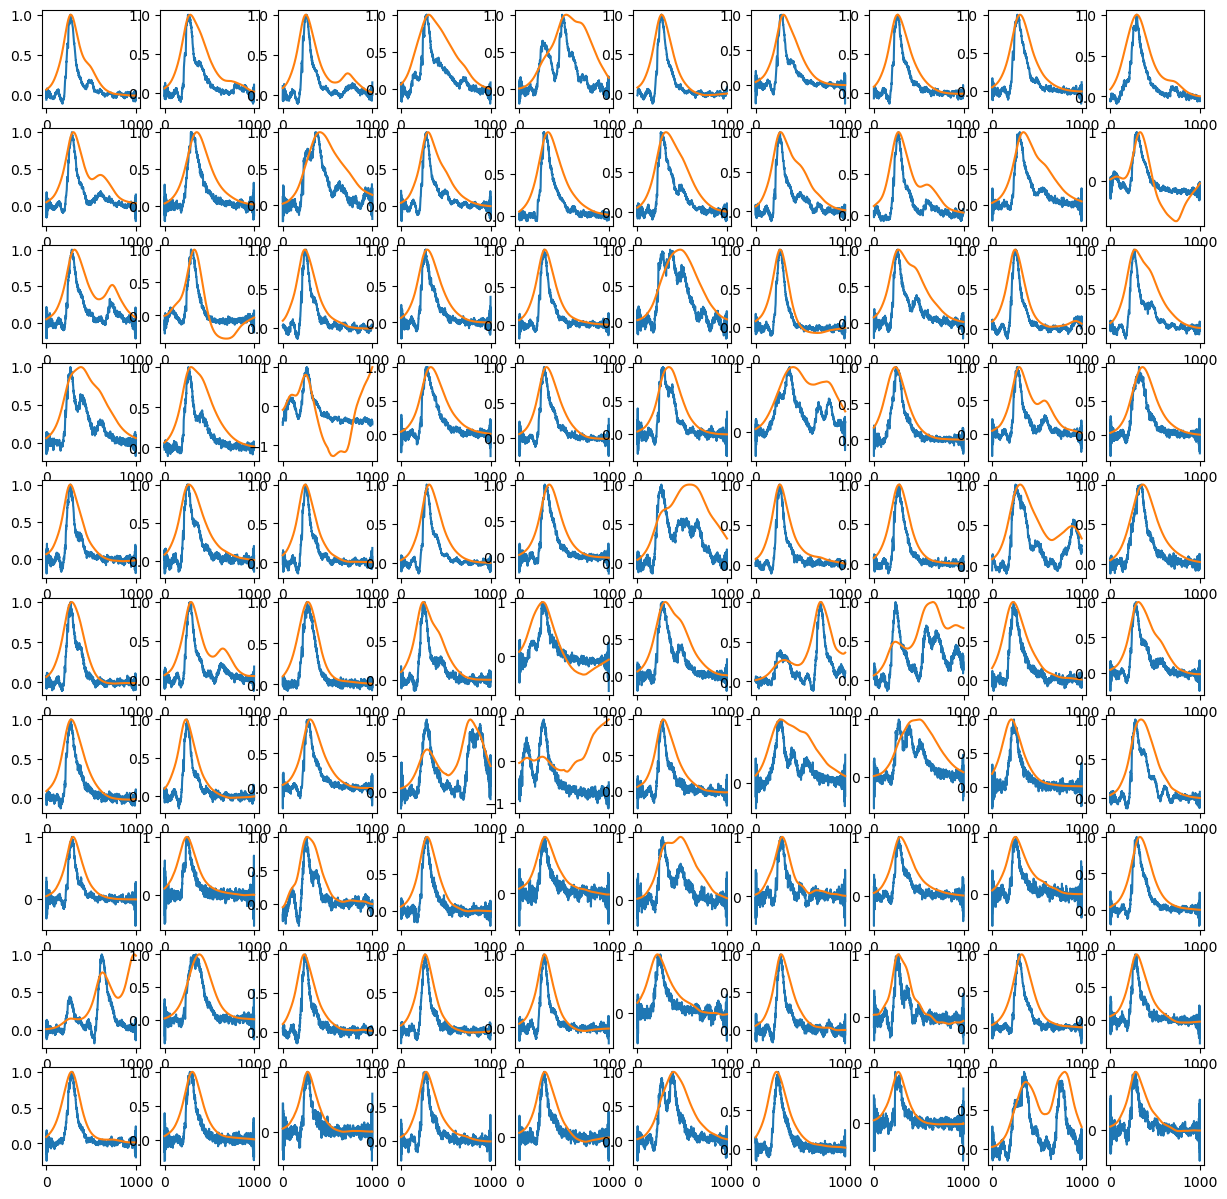

In [81]:
plt.figure(figsize=(15,15))
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.plot(time_array,blcorr_wave[i]/np.max(blcorr_wave[i]))
    plt.plot(time_array,filt_wave[i]/np.max(filt_wave[i]))

In [89]:
qdc=np.zeros(len(waveform))

for i in range(num):
    peak_index=np.argmax(fft_wave[i])
    qdc[i]=np.sum(fft_wave[i][peak_index:peak_index+600])


(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        2.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.00

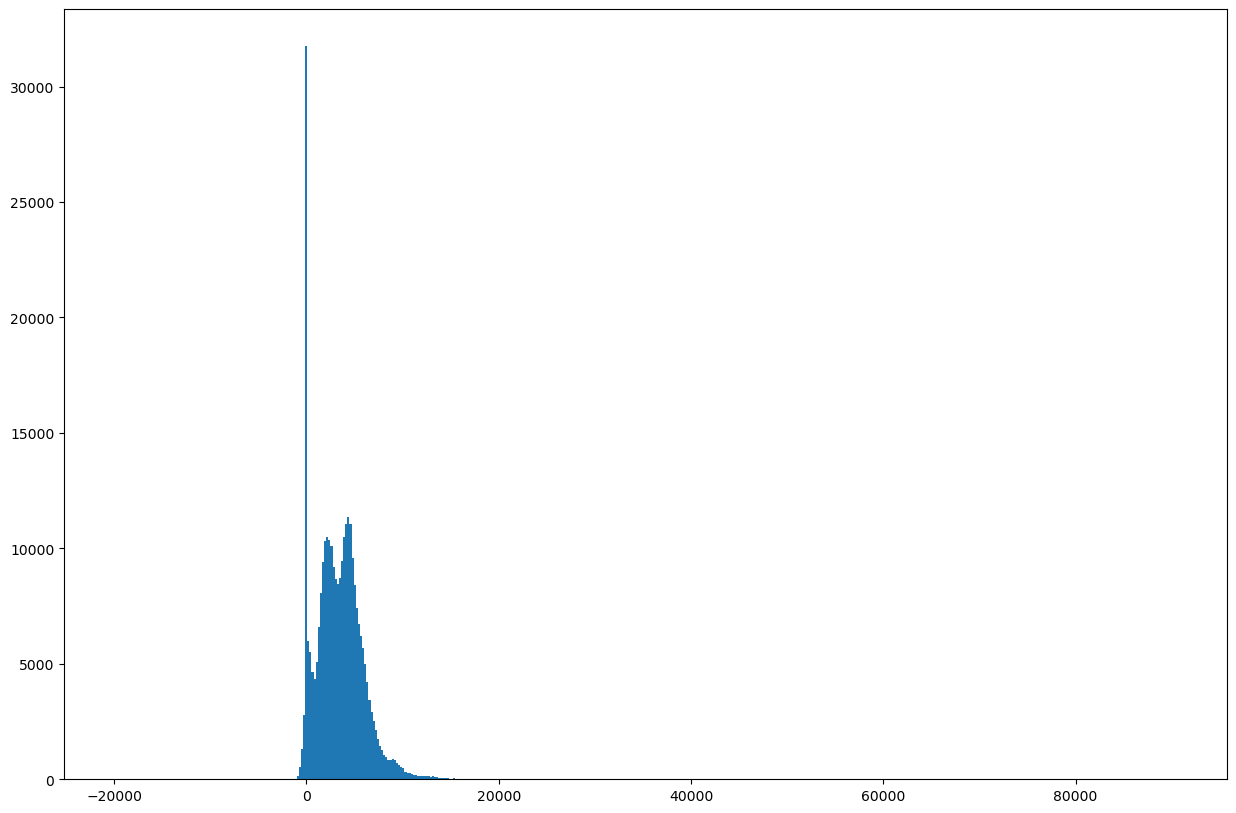

In [91]:
plt.figure(figsize=(15,10))
plt.hist(qdc,bins=500)